---
title: "Processing III: Extracting formants"
---

Because extracting formants is rather tricky with novel vocalizations, we first compare performance of two different extraction pipelines - one using `soundgen` R-package, one using Praat script by XXXX that optimizes formants using XXX

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
import matplotlib.pyplot as plt
import seaborn as sns

curfolder = os.getcwd()

# formants from soundgen
formantfolder1 = curfolder + '/TS_acoustics/'
formants1 = glob.glob(formantfolder1 + 'soundgen*.csv')

# formants from praat
formantfolder2 = curfolder + '/TS_formants/Carignan_formants/'
formants2 = glob.glob(formantfolder2 + '*.Table')

# env 
envfiles = glob.glob(formantfolder1 + '/env_*.csv')

## Pre-processing formants from Praat

First, we want to just loop over all .Table files from Praat and resave them as .csv files

In [4]:
for formant in formants2:
    print('working on ' + formant)
    formant_df = pd.read_csv(formant, sep='\t')

    # get the name of the file
    filename = os.path.basename(formant)
    # get the name of the file without the extension
    filename = os.path.splitext(filename)[0]

    # add to df
    formant_df['filename'] = filename

    # get trialid from the file name 
    trialid = '_'.join(filename.split('_')[0:2] + filename.split('_')[3:4] + filename.split('_')[7:8]) 

    # add empty row in the beginning with time 0 and rest as first row
    copy_row = formant_df.iloc[0].copy()
    # time of this row is 0
    copy_row['time'] = 0

    # add this row to the beginning of the df
    formant_df = pd.concat([pd.DataFrame(copy_row).T, formant_df], ignore_index=True)
    
    # add trialid to the df
    formant_df['trialid'] = trialid

    # write it as csv to formantfolder1
    formant_df.to_csv(formantfolder1 + 'praat_formants_' + trialid + '.csv', index=False)

working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing/TS_formants/Carignan_formants\0_2_pr_0_Mic_nominal_srate48000_p0_juichen_combinatie_c0_formants.Table
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing/TS_formants/Carignan_formants\0_2_pr_19_Mic_nominal_srate48000_p1_glimlach_combinatie_c0_formants.Table
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing/TS_formants/Carignan_formants\0_2_pr_1_Mic_nominal_srate48000_p0_zingen_combinatie_c0_formants.Table
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing/TS_formants/Carignan_formants\0_2_pr_20_Mic_nominal_srate48000_p1_glimlach_combinatie_c1_formants.Table
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing/TS_formants/Carignan_formants\0_2_pr_21_Mic_nominal_srate48000_p1_glimlach_combinatie_c2_formants.Table
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing/TS_formants/Carignan_formants\0_2_pr_22_Mic_nominal_srate48000_p1_klok_combinatie_c0_formants.Table
working on e:\FLESH_Conti

Now we will make from both formant groups two dataframes so that we can compare the spans of formants and whether the ranges are similar, and sensible

In [7]:
# inititate empty df
formants1_df = pd.DataFrame()

# loop over formants 1 and make a giga df from all
for formant in formants1:
    formant_df = pd.read_csv(formant)

    filename = formant.split('\\')[-1]

    # get trialid from the file name (last part separated by /)
    trialid = formant.split('\\')[-1].split('.')[0]
    # get the second-fourth elements separated by _
    trialid = '_'.join(trialid.split('_')[1:4])
    #print(trialid)
    
    # add trialid to the df
    formant_df['trialid'] = trialid

    # add correction info
    if 'c1' in filename:
        formant_df['correction'] = 'c1'
    elif 'c2' in filename:
        formant_df['correction'] = 'c2'
    elif 'c0' in filename:
        formant_df['correction'] = 'c0'
    else:
        formant_df['correction'] = 'none'

    # concatenate
    formants1_df = pd.concat([formants1_df, formant_df])

# get rid of rows with correction = none
formants1_df = formants1_df[formants1_df['correction'] != 'none']

formants1_df.head(15)

,File,duration,duration_noSilence,time,amEnvDep,amEnvDepVoiced,amEnvFreq,amEnvFreqVoiced,amMsFreq,amMsFreqVoiced,...,roughnessVoiced,specCentroid,specCentroidVoiced,specSlope,specSlopeVoiced,subDep,subRatio,voiced,trialid,correction
0,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
1,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
2,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
3,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
4,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
5,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,60,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
6,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
7,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,80,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
8,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,90,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0
9,../01_XDF_processing/data/Data_processed/Data_...,3.142063,1.3,100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0_2_0,c0


In [8]:
# inititate empty df
formants2_df = pd.DataFrame()

# loop over formants 2 and make a giga df from all
for formant in formants2:
    formant_df = pd.read_csv(formant, sep='\t')

    # get the name of the file
    filename = os.path.basename(formant)
    # get the name of the file without the extension
    filename = os.path.splitext(filename)[0]

    # add to df
    formant_df['filename'] = filename

    # get trialid from the file name (first, second and fourth parts separated by _)
    trialid = '_'.join(filename.split('_')[0:2] + filename.split('_')[3:4])
    
    # add trialid to the df
    formant_df['trialid'] = trialid

    # in filename, look for c1, c2, c0
    #if c1, c2, c0 in filename, add to df in column correction
    if 'c1' in filename:
        formant_df['correction'] = 'c1'
    elif 'c2' in filename:
        formant_df['correction'] = 'c2'
    elif 'c0' in filename:
        formant_df['correction'] = 'c0'
    else:
        formant_df['correction'] = 'none'
    
    # concatenate
    formants2_df = pd.concat([formants2_df, formant_df])

# get rid of rows with correction = none
formants2_df = formants2_df[formants2_df['correction'] != 'none']

formants2_df.head(15)

,time,f1,f2,f3,f4,f5,filename,trialid,correction
0,0.026031,1910.072640,3380.992452,5896.442699,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
1,0.031031,1890.080560,3366.165092,5896.610205,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
2,0.036031,1910.066181,3380.974399,5896.442306,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
3,0.041031,1890.092319,3366.156404,5896.609863,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
4,0.046031,1910.073207,3380.962077,5896.441999,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
5,0.051031,1890.087965,3366.149616,5896.609697,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
6,0.056031,1910.062802,3380.953514,5896.441903,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
7,0.061031,1890.085211,3366.138214,5896.609723,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
8,0.066031,1910.063561,3380.941686,5896.442068,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0
9,0.071031,1890.080307,3366.122801,5896.610225,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0,c0


Now we can compare the formants extracted by both methods

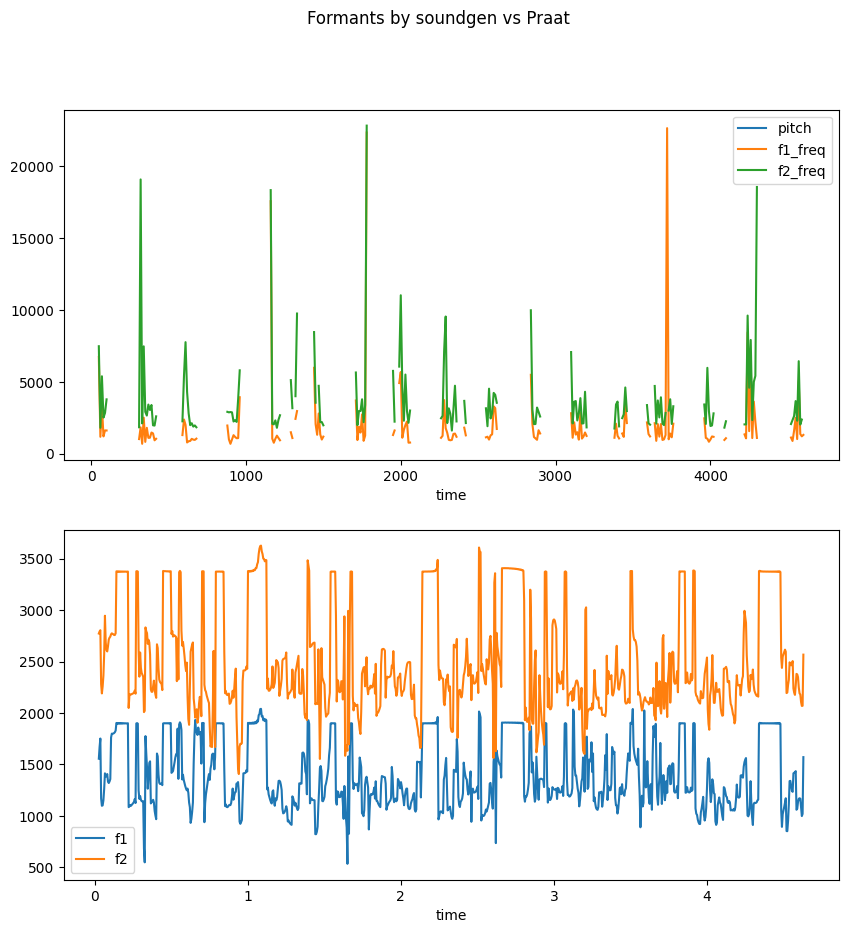

In [ ]:
# pick a random trialid from formants1_df
trialid = formants1_df['trialid'].sample(1).values[0]

# get the formants for this trialid from both dfs
formants1_trial = formants1_df[formants1_df['trialid'] == trialid]
formants2_trial = formants2_df[formants2_df['trialid'] == trialid]

# plot the formants as time series, as two grids from each df
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

formants1_trial.plot(x='time', y=['pitch', 'f1_freq', 'f2_freq'], ax=axs[0])
formants2_trial.plot(x='time', y=['f1', 'f2'], ax=axs[1])

# title
plt.suptitle('Formants by soundgen vs Praat')
plt.show()

And also the vocal space area

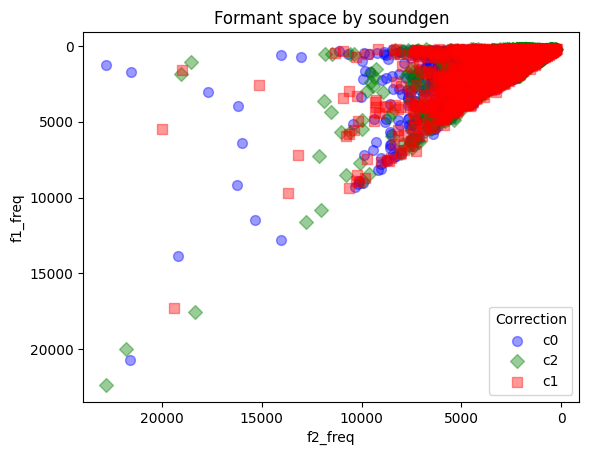

In [ ]:
# Define the color and shape mapping for each unique correction
color_mapping = {'c0': 'blue', 'c1': 'red', 'c2': 'green'}
shape_mapping = {'c0': 'o', 'c1': 's', 'c2': 'D'}  # 'o' = circle, 's' = square, 'D' = diamond

# Create the plot
for correction in formants1_df['correction'].unique():
    subset = formants1_df[formants1_df['correction'] == correction]
    plt.scatter(subset['f2_freq'], subset['f1_freq'],
                color=color_mapping[correction],
                marker=shape_mapping[correction],
                s=50,
                label=correction,
                alpha=0.4)

# Reverse axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Labels
plt.xlabel('f2_freq')
plt.ylabel('f1_freq')

# title
plt.title('Formant space by soundgen')

# Add legend for colors and shapes
plt.legend(title="Correction")
plt.show()


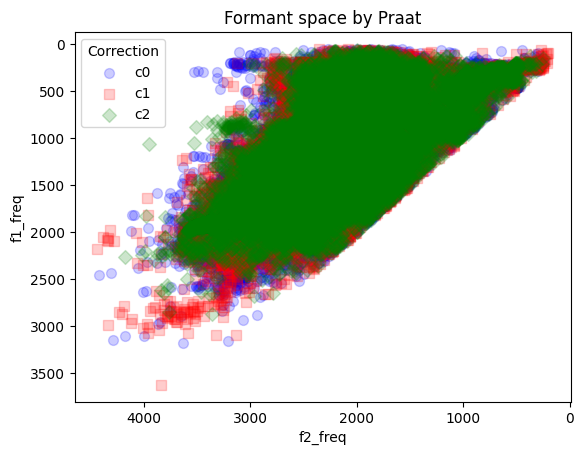

In [ ]:
# Define the color and shape mapping for each unique correction
color_mapping = {'c0': 'blue', 'c1': 'red', 'c2': 'green'}
shape_mapping = {'c0': 'o', 'c1': 's', 'c2': 'D'}  # 'o' = circle, 's' = square, 'D' = diamond

# Create the plot
for correction in formants2_df['correction'].unique():
    subset = formants2_df[formants2_df['correction'] == correction]
    plt.scatter(subset['f2'], subset['f1'],
                color=color_mapping[correction],
                marker=shape_mapping[correction],
                s=50,
                label=correction,
                alpha=0.2)

# Reverse axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Labels
plt.xlabel('f2_freq')
plt.ylabel('f1_freq')

# title
plt.title('Formant space by Praat')

# Add legend for colors and shapes
plt.legend(title="Correction")
plt.show()


This is the distribution

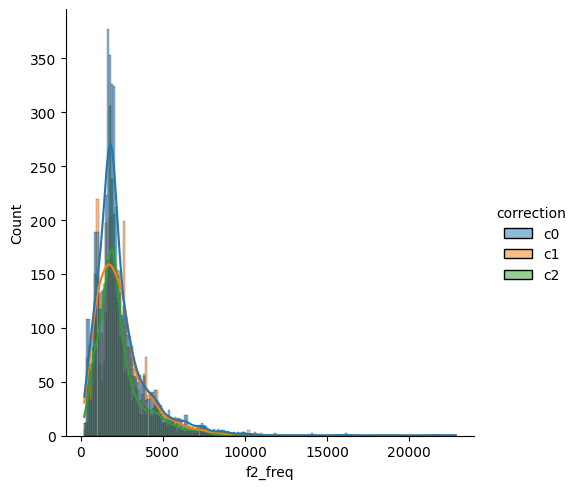

In [ ]:
# correction as factor
formants1_df['correction'] = pd.Categorical(formants1_df['correction'])

# reset index
df_results = formants1_df.reset_index(drop=True)

# plot desnity of f1_freq , each correction separately
sns.displot(data=df_results, x='f2_freq', hue='correction', fill=True, kde=True)

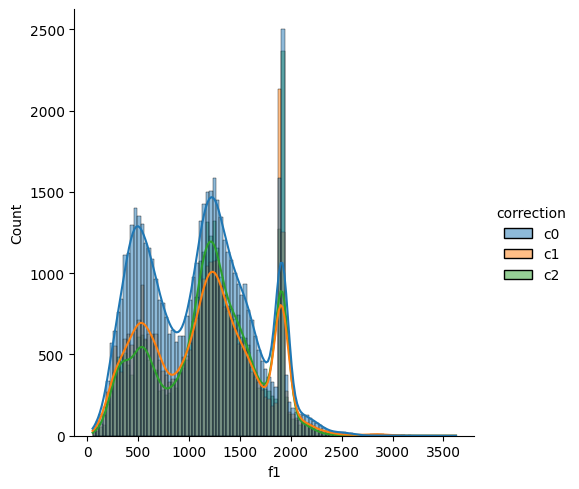

In [17]:
# correction as factor
formants2_df['correction'] = pd.Categorical(formants2_df['correction'])

# reset index
df_results = formants2_df.reset_index(drop=True)

# plot desnity of f1_freq , each correction separately
sns.displot(data=df_results, x='f1', hue='correction', fill=True, kde=True)

The values look much more reasonable for the Praat extraction, so we will use this for the rest of the analysis

# Envelope peaks as a reference point for formants

Formant values are most reliable where f0 is present. However, in this project, we work with non-speech sounds, meaning that they are frequently unvoiced. Because research shows that there are also formants beyond f0 contour (REF-RAPH), we will also consider formant values in the moments of envelope peaks. This will maximize the number of data points we can use for analysis.

We can use findpeaks() function from the signal package to find the peaks in the envelope. We can then use these peaks as a reference point for formant extraction.

In [18]:
env_df = pd.DataFrame()

# loop over env files and make a giga df from all
for envfile in envfiles:
    df = pd.read_csv(envfile)
    env_df = pd.concat([env_df, df])

# in the trialID column, get rid of the last element separated by _
env_df['trialid'] = env_df['trialID'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# get rid of the trialID column
env_df = env_df.drop(columns=['trialID'])

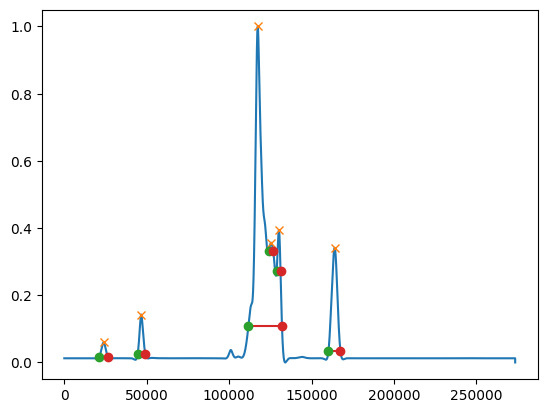

In [ ]:
# pick a random trialid from env_df
trialid = env_df['trialid'].sample(1).values[0]

# get the env for this trialid from env_df
env_trial = env_df[env_df['trialid'] == trialid]

# find peaks, min height is mean of the env
peaks, _ = find_peaks(env_trial['envelope'], height=np.mean(env_trial['envelope']))

# get the width of the peaks
results_half = peak_widths(env_trial['envelope'], peaks, rel_height=0.5)
results_full = peak_widths(env_trial['envelope'], peaks, rel_height=0.9)

# plot the env as time series
plt.plot(env_trial['envelope'])
# plot the peaks
plt.plot(peaks, env_trial['envelope'][peaks], "x")
# plot the width of the peaks
#plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
# plot the start and end of the peaks
plt.plot(results_full[2], env_trial['envelope'][results_full[2].astype(int)], "o")
plt.plot(results_full[3], env_trial['envelope'][results_full[3].astype(int)], "o")

plt.show()




Now let's check it against the formants extracted by Praat

In [22]:
# find formants2 df with the same trialid
formants2_trial = formants2_df[formants2_df['trialid'] == trialid]

# convert time to ms
formants2_trial['time'] = formants2_trial['time'] * 1000

# merge formants1 and formants2 on trialid and time, outer method
merged_df = pd.merge(env_trial, formants2_trial, on=['trialid', 'time'], how='outer')


# cols to int
colstoint = ['f1', 'f2', 'f3', 'f4', 'f5']

# interpolate f1-f5 on time
# interpolate 
for col in colstoint:
    merged_df[col] = merged_df[col].interpolate(method='linear', x = merged_df['time'])

# delete rows where envelope is NaN
merged_df = merged_df.dropna(subset=['envelope'])


C:\Users\kadava\AppData\Local\Temp\ipykernel_26284\3388615306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formants2_trial['time'] = formants2_trial['time'] * 1000


We will now annotate in the dataframe where are peak widths, so that we know which values of formants to consider (the rest we turn to NA)

In [23]:
# check the width of the peaks

# find peaks, min height is mean of the env
peaks, _ = find_peaks(merged_df['envelope'], height=np.mean(merged_df['envelope']))

# get the width of the peaks
results_half = peak_widths(merged_df['envelope'], peaks, rel_height=0.9)

# create column peak_width and put 1 everywhere between start and end of the peak
merged_df['peak_width'] = 0

# create a table from the results_half[2] and results_half[3]

peak_w = pd.DataFrame({'start': results_half[2], 'end': results_half[3]})

# loop over the rows of the peak_w and put 1 in the peak_width column between start and end
for i, row in peak_w.iterrows():
    merged_df.loc[row['start']:row['end'], 'peak_width'] = 1


# for each formant column, create new f_clean column and put the value of the formant where peak_width = 1
for col in colstoint:
    merged_df[col + '_clean'] = merged_df[col] * merged_df['peak_width']
    # instead of 0, put NaN
    merged_df[col + '_clean'] = merged_df[col + '_clean'].replace(0, np.nan)


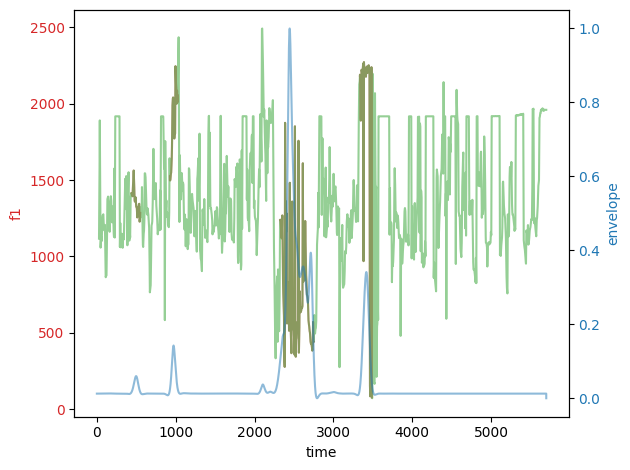

In [28]:
# plot f1 and envelope such that each has its own y-axis

fig, ax1 = plt.subplots()

color = 'tab:red'
color1 = 'tab:green'
ax1.set_xlabel('time')
ax1.set_ylabel('f1', color=color)

ax1.plot(merged_df['time'], merged_df['f1_clean'], color=color, alpha=0.5)
ax1.plot(merged_df['time'], merged_df['f1'], color=color1, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.set_ylabel('envelope', color=color)
ax2.plot(merged_df['time'], merged_df['envelope'], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


In script XX, we will use both envelope and f0 to define the relevant formant windows.